# Assignment 3
In this assignment we used the completed BooleanModeling.ipynb notebook from the practical as a starting point to create 4 different mutated versions of the cell regulatory network by modifying the Boolean rules.

In [285]:
# Setup and Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

### Helper functions to create a Boolean network
We used the helper class provided in the practical to build and simulate a boolean network

In [287]:
# Helper class to build and simulate boolean network from the practical

class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                # print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)

### Function to build the normal network
In the practical we already were given a "normal network" with it's boolean rules. We use the code from that to create a function which will build the normal network. Later, we will introduce mutations by overriding some of these rules

In [289]:
def build_normal_network():
    nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
    network = BooleanNetwork(nodes)

    # Normal (healthy) rules
    # Define Boolean rules (based on real biology, simplified)
    network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
    network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
    network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
    network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
    network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
    network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
    network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
    network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

    return network, nodes


## Mutations
We now create 4 different mutated versions of the cell regulatory network by modifying the Boolean rules as given in the assignment:
* Mutation A: p53 Knockout (Loss of tumor suppressor)
* Mutation B: MYC Amplification (Oncogene overexpression)
* Mutation C: MDM2 Overexpression (p53 pathway disruption)
* Mutation D: p21 Loss (we decided to force p21 permanently OFF)

In [291]:
def apply_mutation(network, mutation):
    if mutation == "p53_KO":  # p53 knockout
        network.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)") # Mutation A

    elif mutation == "MYC_overexpression":  # MYC always ON
        network.add_rule('MYC', lambda s: True, "MYC = AMPLIFIED (always ON)") # Mutation B

    elif mutation == "MDM2_overexpression":  # MDM2 always ON
        network.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)") # Mutation C

    elif mutation == "p21_loss":  # p21 always OFF
        network.add_rule('p21', lambda s: False, "p21 = BROKEN (always OFF)") # Mutation D

    return network

# Scenario Analysis
In the practical we first ran the three scenarios (Healthy Cell, Stressed Cell, Oncogene Hijacked Cell) step by step.  
Here, we collect that same logic into a function so we can easily reuse it for the Normal Network and each of the mutation cases (A–D).  

### Function to run the scenarios and plot
The following function uses the code from the practical to run the simulation for all three scenarios

In [294]:
def run_scenarios_and_plot(network, label, scenarios, steps=8):
    results = {}

    # Run Healthy Cell
    s = "Healthy Cell"
    initial_state = scenarios[s]
    network.set_state(**initial_state)
    trajectory = network.simulate(steps=steps)
    results[s] = trajectory

    final_state = trajectory[-1]
    node_names = sorted(network.nodes.keys())
    final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
    print(f"{label} | {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

    # Run Stressed Cell
    m = "Stressed Cell"
    initial_state = scenarios[m]
    network.set_state(**initial_state)
    trajectory = network.simulate(steps=steps)
    results[m] = trajectory

    final_state = trajectory[-1]
    node_names = sorted(network.nodes.keys())
    final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
    print(f"{label} | {m}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

    # Run Oncogene Hijacked Cell
    o = "Oncogene Hijacked Cell"
    initial_state = scenarios[o]
    network.set_state(**initial_state)
    trajectory = network.simulate(steps=steps)
    results[o] = trajectory

    final_state = trajectory[-1]
    node_names = sorted(network.nodes.keys())
    final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
    print(f"{label} | {o}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

    # Visualize results
    n_scenarios = len(results)
    fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))

    if n_scenarios == 1:
        axes = [axes]

    for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
        ax = axes[scenario_idx]

        # Create heatmap
        trajectory_matrix = trajectory.T  # Transpose for proper orientation
        im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

        # Formatting
        ax.set_title(f'{label} - {scenario_name}', fontweight='bold', fontsize=12)
        ax.set_xlabel('Time Steps', fontsize=10)
        ax.set_ylabel('Network Nodes', fontsize=10)
        ax.set_yticks(range(len(node_names)))
        ax.set_yticklabels(node_names, fontsize=9)

        # Add text annotations
        for t in range(trajectory.shape[0]):
            for n in range(len(node_names)):
                color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
                ax.text(t, n, int(trajectory_matrix[n, t]),
                        ha="center", va="center", color=color, fontweight='bold')

        # Highlight key outputs
        output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
        for output_idx in output_indices:
            ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

    plt.suptitle(f'Boolean Network Dynamics: {label}',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


### Analysis on Mutations A-D

Normal Network | Healthy Cell: Final state: Growth=1, Death=0, p53=0
Normal Network | Stressed Cell: Final state: Growth=0, Death=1, p53=1
Normal Network | Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


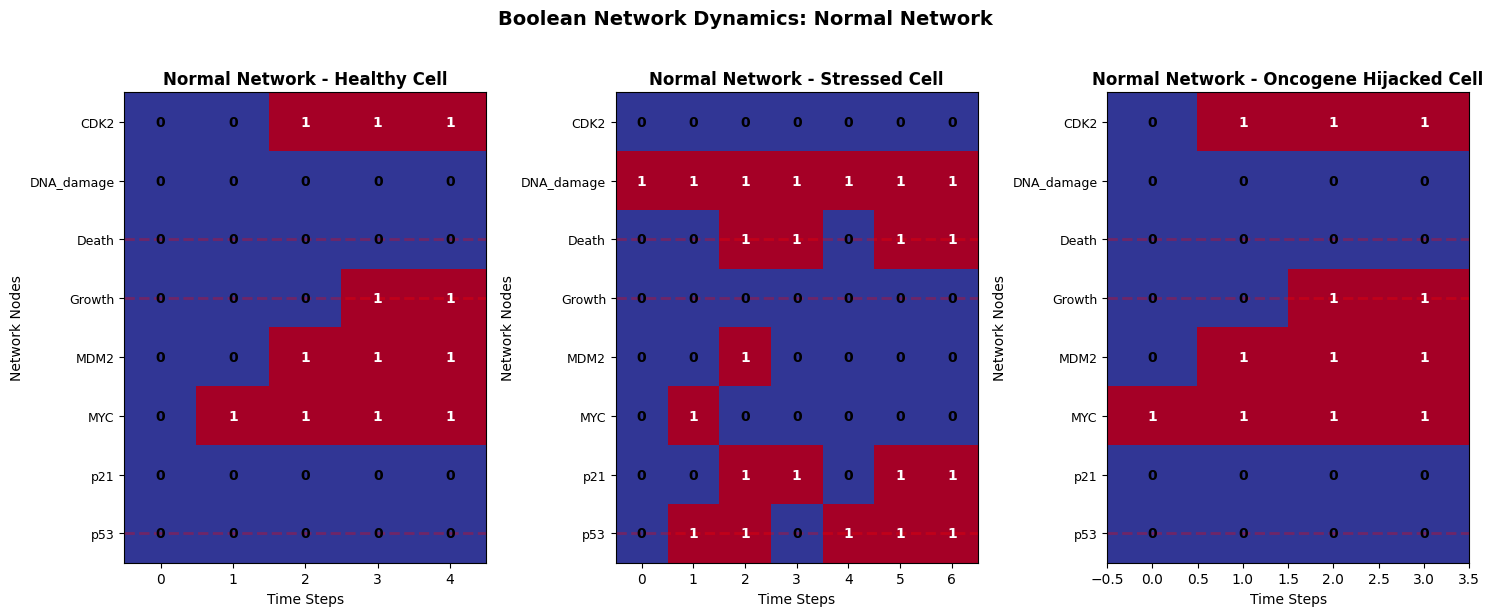

Mutation A (p53 KO) | Healthy Cell: Final state: Growth=1, Death=0, p53=0
Mutation A (p53 KO) | Stressed Cell: Final state: Growth=1, Death=0, p53=0
Mutation A (p53 KO) | Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


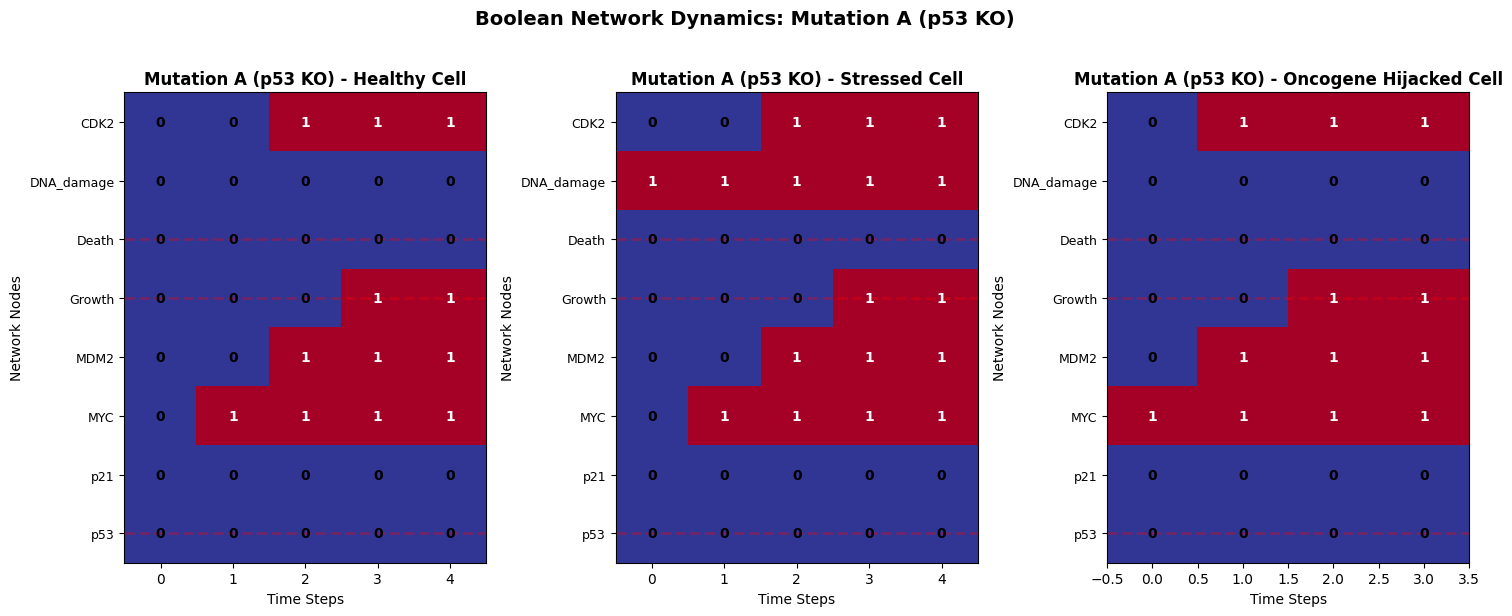

Mutation B (MYC OE) | Healthy Cell: Final state: Growth=1, Death=0, p53=0
Mutation B (MYC OE) | Stressed Cell: Final state: Growth=1, Death=0, p53=0
Mutation B (MYC OE) | Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


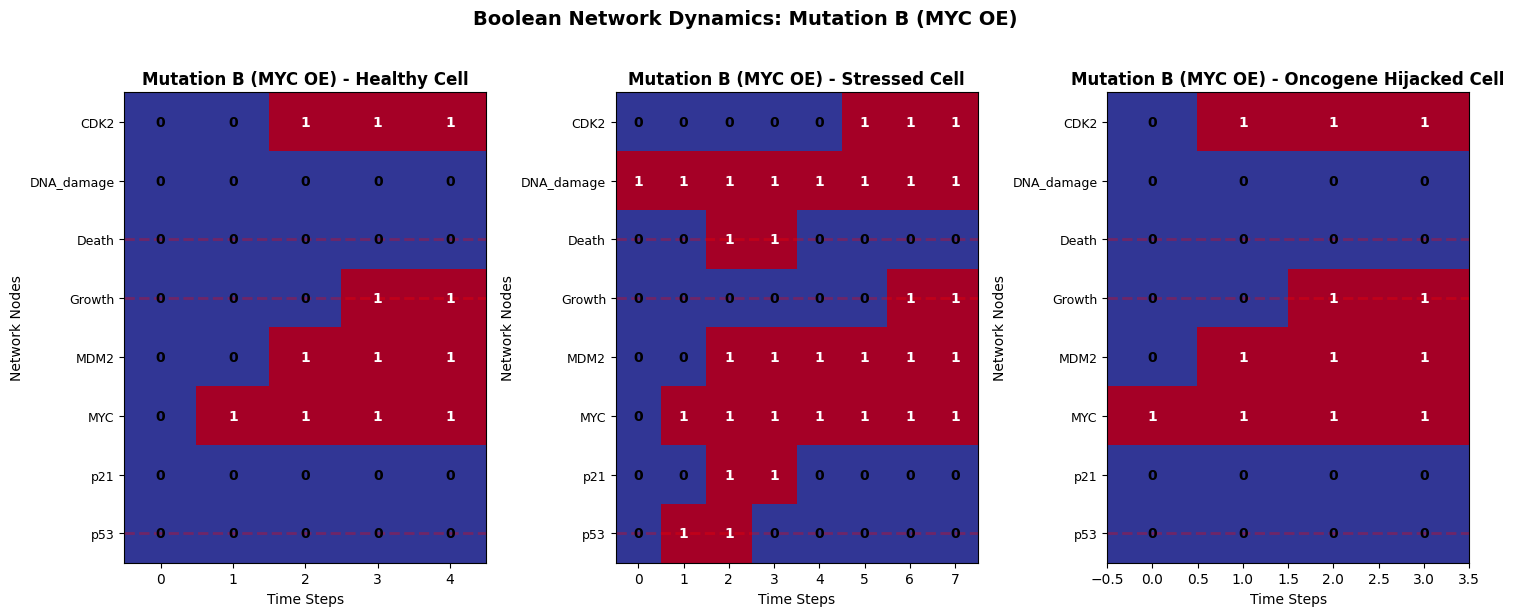

Mutation C (MDM2 OE) | Healthy Cell: Final state: Growth=1, Death=0, p53=0
Mutation C (MDM2 OE) | Stressed Cell: Final state: Growth=1, Death=0, p53=0
Mutation C (MDM2 OE) | Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


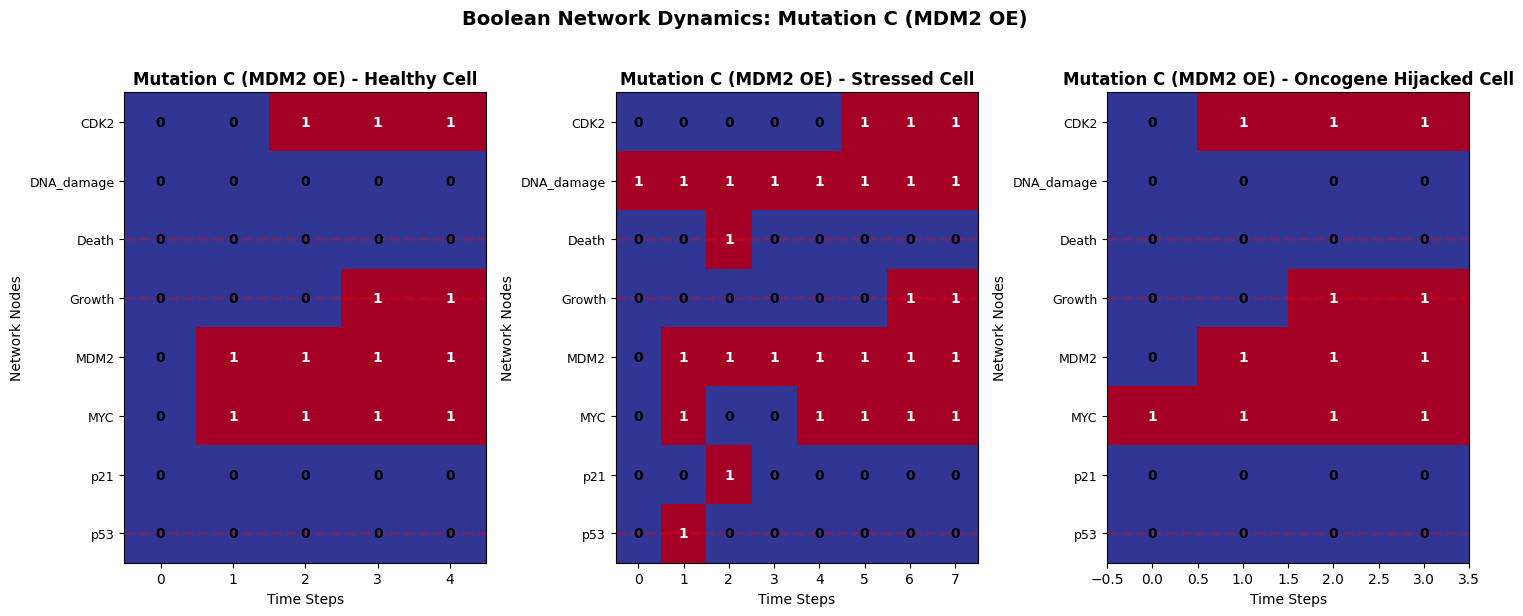

Mutation D (p21 OFF) | Healthy Cell: Final state: Growth=1, Death=0, p53=0
Mutation D (p21 OFF) | Stressed Cell: Final state: Growth=0, Death=1, p53=1
Mutation D (p21 OFF) | Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


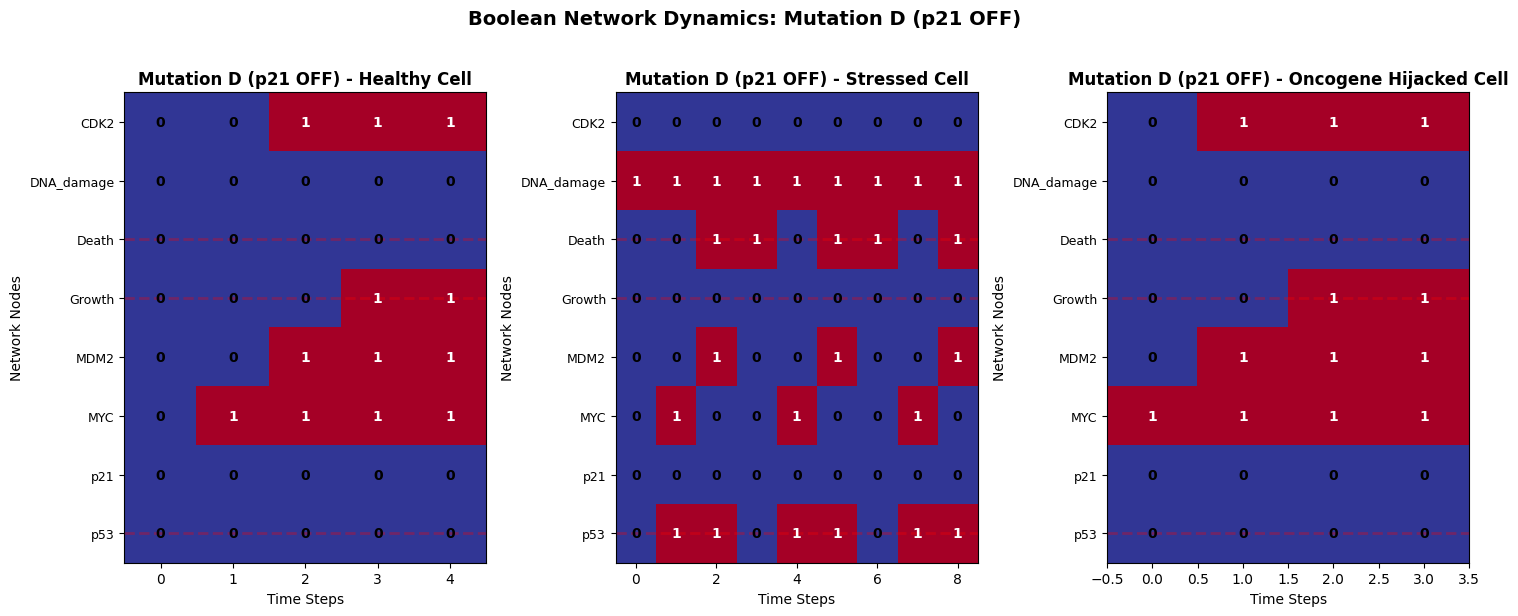

In [296]:
# Define scenarios 
scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

# Normal network
normal_net, nodes = build_normal_network()
run_scenarios_and_plot(normal_net, "Normal Network", scenarios)

# Mutation A
mut_A, nodes = build_normal_network()
mut_A = apply_mutation(mut_A, "p53_KO")
run_scenarios_and_plot(mut_A, "Mutation A (p53 KO)", scenarios)

# Mutation B
mut_B, nodes = build_normal_network()
mut_B = apply_mutation(mut_B, "MYC_overexpression")
run_scenarios_and_plot(mut_B, "Mutation B (MYC OE)", scenarios)

# Mutation C
mut_C, nodes = build_normal_network()
mut_C = apply_mutation(mut_C, "MDM2_overexpression")
run_scenarios_and_plot(mut_C, "Mutation C (MDM2 OE)", scenarios)

# Mutation D
mut_D, nodes = build_normal_network()
mut_D = apply_mutation(mut_D, "p21_loss")
run_scenarios_and_plot(mut_D, "Mutation D (p21 OFF)", scenarios)

## Conclusions:
* **Normal Network** - The normal network behaves as expected: healthy cells proliferate, stressed cells undergo apoptosis via p53 activation, and oncogene hijacking drives growth when no stress is present. This provides a baseline to compare how mutations alter these cell fate decisions.
* **Mutation A** - With p53 knocked out, all scenarios converge to uncontrolled growth (Growth=ON, Death=OFF, p53=OFF), even under DNA damage. This shows that loss of p53 disables the cell’s ability to trigger apoptosis or arrest, driving tumor-like behavior in every condition.
* **Mutation B** - Persistent MYC drives proliferation in all scenarios (Growth=ON, Death=OFF), including under DNA damage. In this mutation, constant MYC elevates MDM2, which quickly shuts down p53, blocking apoptosis and arrest.
* **Mutation C** - With MDM2 permanently ON, p53 is suppressed in all conditions, so every scenario ends in unchecked growth (Growth=ON, Death=OFF). This shows that MDM2 overexpression disables the DNA damage response and prevents apoptosis, similar to a p53 knockout.
* **Mutation D** - With p21 permanently OFF, healthy and oncogene-driven cells keep proliferating (Growth=ON, Death=OFF), but stressed cells still trigger apoptosis via p53. This shows that loss of p21 removes growth inhibition yet does not fully abolish the DNA damage–induced death response.

# Attractor Analysis
Here we systematically explore all possible initial states of the network to identify its attractors.  
Once again, we used the code from the practical to create functions that help us do this analysis on all four mutations and the normal network.

### Actractor finder and Interpretation Function

In [300]:
def find_attractors(network, max_steps=15):
    import itertools
    attractors = []
    node_names = sorted(network.nodes.keys())
    n_nodes = len(node_names)

    print(f"Testing all {2**n_nodes} possible initial states...")

    all_states = list(itertools.product([0, 1], repeat=n_nodes))

    for initial_state in all_states:
        state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
        network.set_state(**state_dict)

        trajectory = network.simulate(steps=8)

        if len(trajectory) >= 2:
            final_state = tuple(trajectory[-1])

            if np.array_equal(trajectory[-1], trajectory[-2]):
                if final_state not in attractors:
                    attractors.append(final_state)

    print(f"\nFOUND {len(attractors)} ATTRACTORS:")

    for i, attractor in enumerate(attractors):
        print(f"\nAttractor {i+1}: {list(attractor)}")
        state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

        growth_active = state_dict['Growth'] == 1
        death_active = state_dict['Death'] == 1
        p53_active = state_dict['p53'] == 1
        dna_damage_active = state_dict['DNA_damage'] == 1

        print(f"   Growth: {'ON' if growth_active else 'OFF'}")
        print(f"   Death: {'ON' if death_active else 'OFF'}")
        print(f"   p53: {'ON' if p53_active else 'OFF'}")
        print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

        if growth_active and not death_active and not dna_damage_active:
            interpretation = "Healthy proliferating cell (normal growth, no stress)"
        elif death_active and not growth_active:
            interpretation = "Cell death/apoptosis state (growth halted, death active)"
        elif growth_active and not death_active and dna_damage_active and not p53_active:
            interpretation = "Uncontrolled growth despite DNA damage (possible tumor-like state)"
        elif p53_active and dna_damage_active and not growth_active:
            interpretation = "DNA damage response triggered (p53 active, growth arrested)"
        else:
            interpretation = "CONFLICT - Unusual state"

        print(f"   → {interpretation}")

    # Convert attractors to clean matrix
    attractor_matrix = []
    for attractor in attractors:
        clean_row = [int(x) for x in attractor]
        attractor_matrix.append(clean_row)

    attractor_matrix = np.array(attractor_matrix)

    # Plot heatmap
    plt.figure(figsize=(10, max(6, len(attractors))))
    ax = sns.heatmap(attractor_matrix,
                     xticklabels=node_names,
                     yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                     cmap='RdYlBu_r',
                     cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                     annot=True,
                     fmt='d',
                     linewidths=0.5)

    plt.title('Boolean Network Attractors: Final States Comparison',
              fontsize=14, fontweight='bold')
    plt.xlabel('Network Nodes', fontsize=12)
    plt.ylabel('Attractors', fontsize=12)

    output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
    for node in output_nodes:
        if node in node_names:
            idx = node_names.index(node)
            ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

    plt.tight_layout()
    plt.show()

    return attractors, node_names


## Basin of Attraction Analysis
After finding the attractors, we determine the basins of attraction which is the number of initial states that lead into each attractor. 

In [302]:
def analyze_basins(network, attractors, node_names, max_steps=15):
    from collections import defaultdict
    from itertools import product

    basin_data = defaultdict(list)
    attractor_map = {}

    n_nodes = len(node_names)
    all_states = list(product([0, 1], repeat=n_nodes))
    print(f"Analyzing {len(all_states)} initial states...")

    for initial_state in all_states:
        state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
        network.set_state(**state_dict)

        trajectory = network.simulate(steps=max_steps, record_history=True)

        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(int(x) for x in trajectory[-1])

            for att_idx, attractor in enumerate(attractors):
                clean_attractor = tuple(int(x) for x in attractor)
                if final_state == clean_attractor:
                    basin_data[att_idx].append(initial_state)
                    attractor_map[initial_state] = att_idx
                    break

    # Basin sizes
    print(f"\nBasin Sizes:")
    total_states = len(all_states)
    basin_sizes = []
    basin_labels = []

    for att_idx, attractor in enumerate(attractors):
        basin_size = len(basin_data[att_idx])
        percentage = (basin_size / total_states) * 100

        state_dict = dict(zip(node_names, attractor))
        growth_active = state_dict['Growth'] == 1
        death_active = state_dict['Death'] == 1
        p53_active = state_dict['p53'] == 1
        dna_damage_active = state_dict['DNA_damage'] == 1

        if growth_active and not death_active and not dna_damage_active:
            interpretation = "Healthy proliferating cell"
        elif death_active and not growth_active:
            interpretation = "Apostosis"
        elif growth_active and not death_active and dna_damage_active and not p53_active:
            interpretation = "Tumor-like (growth with DNA damage)"
        elif p53_active and dna_damage_active and not growth_active:
            interpretation = "DNA damage response"
        else:
            interpretation = "CONFLICT - Unusual state"

        print(f"   → {interpretation}")

        print(f" Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%) → {interpretation}")

        basin_sizes.append(basin_size)
        basin_labels.append(f"{interpretation}\n({percentage:.1f}%)")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))
    wedges, texts, autotexts = ax1.pie(basin_sizes,
                                       labels=basin_labels,
                                       colors=colors,
                                       autopct='%1.1f%%',
                                       startangle=90)

    ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"',
                  fontsize=12, fontweight='bold')

    attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
    bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)

    ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Initial States', fontsize=10)
    ax2.set_xlabel('Attractors', fontsize=10)

    for bar, size, label in zip(bars, basin_sizes, basin_labels):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}\n{label.split()[0]}',
                 ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return basin_data, attractor_map


### Normal Network Attractor Analysis

Testing all 256 possible initial states...

FOUND 3 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy proliferating cell (normal growth, no stress)

Attractor 2: [0, 1, 1, 0, 0, 0, 1, 1]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → Cell death/apoptosis state (growth halted, death active)

Attractor 3: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Uncontrolled growth despite DNA damage (possible tumor-like state)


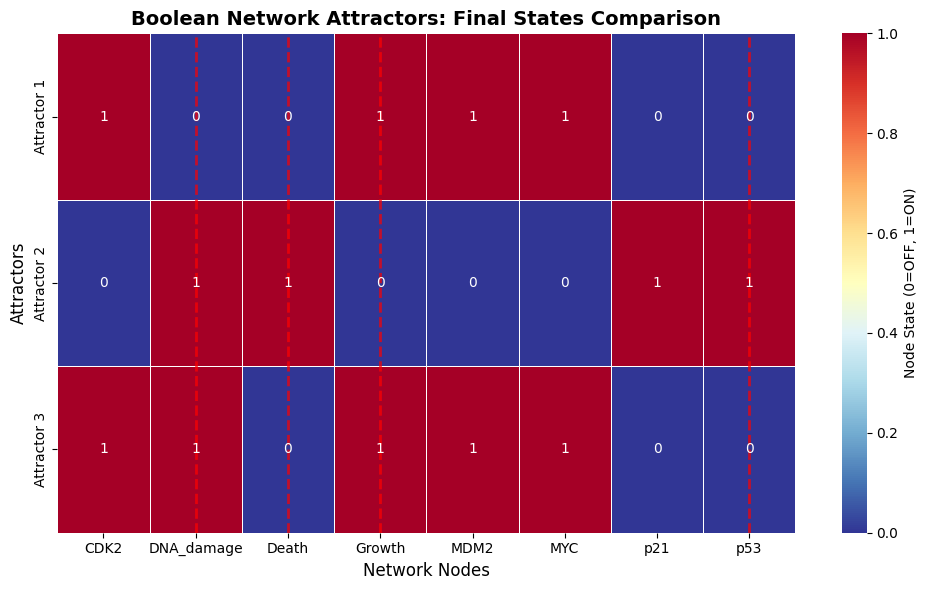

Analyzing 256 initial states...

Basin Sizes:
   → Healthy proliferating cell
 Attractor 1: 128 states ( 50.0%) → Healthy proliferating cell
   → Apostosis
 Attractor 2: 120 states ( 46.9%) → Apostosis
   → Tumor-like (growth with DNA damage)
 Attractor 3:   8 states (  3.1%) → Tumor-like (growth with DNA damage)


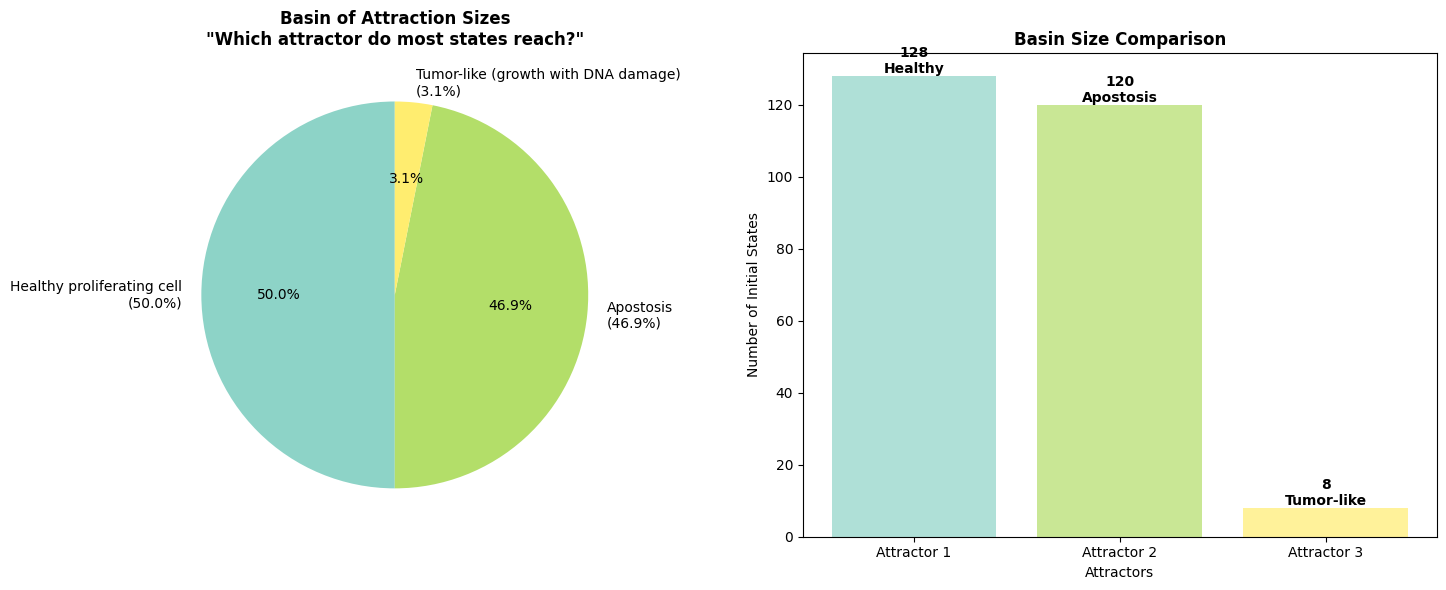

In [304]:
normal_net, nodes = build_normal_network()

# Find attractors
attractors_normal, node_names_normal = find_attractors(normal_net, max_steps=15)

# Analyze basins
basin_data_normal, attractor_map_normal = analyze_basins(normal_net, attractors_normal, node_names_normal, max_steps=15)

### Mutation A: p53 KO Attractor Analysis

Testing all 256 possible initial states...

FOUND 2 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy proliferating cell (normal growth, no stress)

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Uncontrolled growth despite DNA damage (possible tumor-like state)


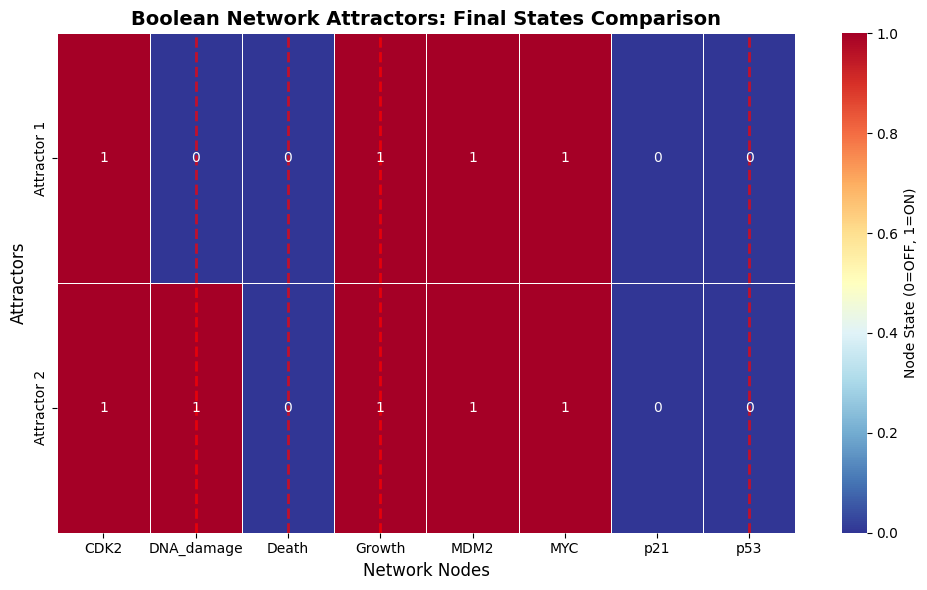

Analyzing 256 initial states...

Basin Sizes:
   → Healthy proliferating cell
 Attractor 1: 128 states ( 50.0%) → Healthy proliferating cell
   → Tumor-like (growth with DNA damage)
 Attractor 2: 128 states ( 50.0%) → Tumor-like (growth with DNA damage)


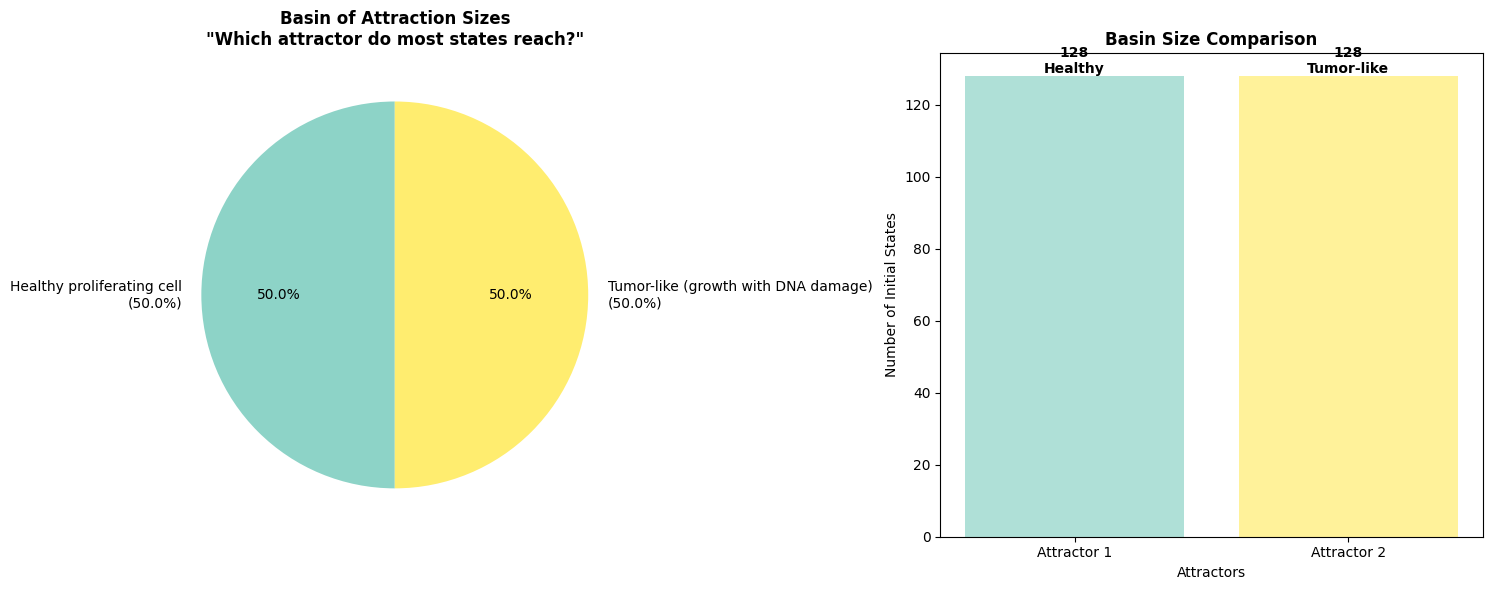

In [306]:
mut_A, nodes = build_normal_network()
mut_A = apply_mutation(mut_A, "p53_KO")

# Find attractors
attractors_A, node_names_A = find_attractors(mut_A, max_steps=15)

# Analyze basins
basin_data_A, attractor_map_A = analyze_basins(mut_A, attractors_A, node_names_A, max_steps=15)

### Mutation B: MYC OE Attractor Analysis

Testing all 256 possible initial states...

FOUND 3 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy proliferating cell (normal growth, no stress)

Attractor 2: [0, 1, 1, 0, 0, 0, 1, 1]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → Cell death/apoptosis state (growth halted, death active)

Attractor 3: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Uncontrolled growth despite DNA damage (possible tumor-like state)


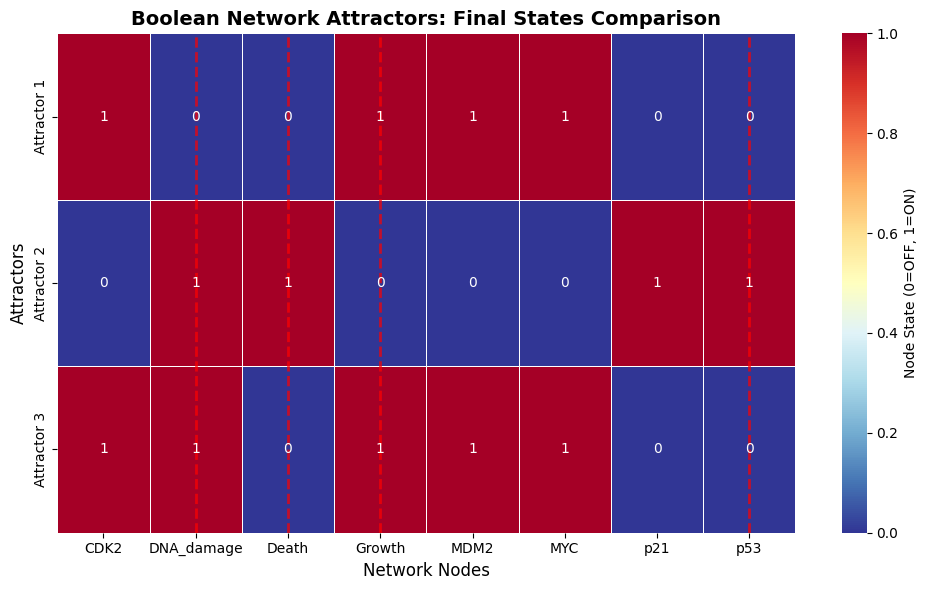

Analyzing 256 initial states...

Basin Sizes:
   → Healthy proliferating cell
 Attractor 1: 128 states ( 50.0%) → Healthy proliferating cell
   → Apostosis
 Attractor 2: 120 states ( 46.9%) → Apostosis
   → Tumor-like (growth with DNA damage)
 Attractor 3:   8 states (  3.1%) → Tumor-like (growth with DNA damage)


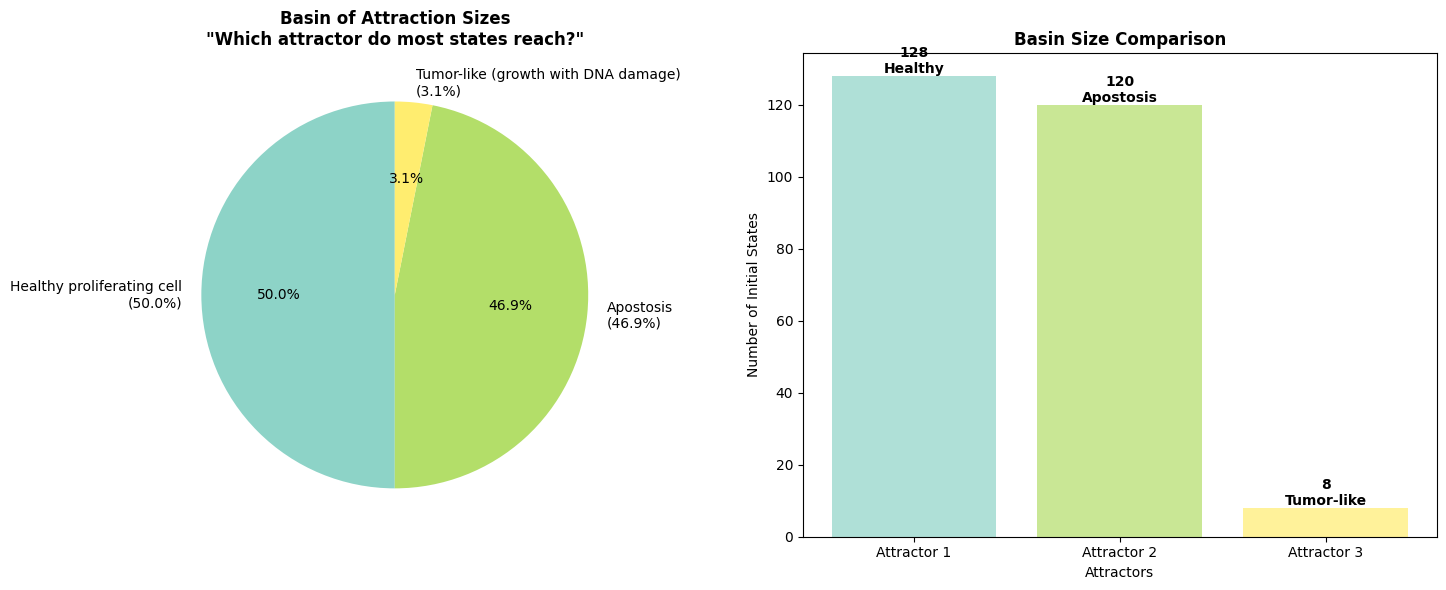

In [308]:
mut_B, nodes = build_normal_network()
mut_B = apply_mutation(mut_B, "MYC_overexpression")

# Find attractors
attractors_B, node_names_B = find_attractors(mut_B, max_steps=15)

# Analyze basins
basin_data_B, attractor_map_B = analyze_basins(mut_B, attractors_B, node_names_B, max_steps=15)

### Mutation C: MDM2 Overexpression Attractor Analysis

Testing all 256 possible initial states...

FOUND 2 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy proliferating cell (normal growth, no stress)

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Uncontrolled growth despite DNA damage (possible tumor-like state)


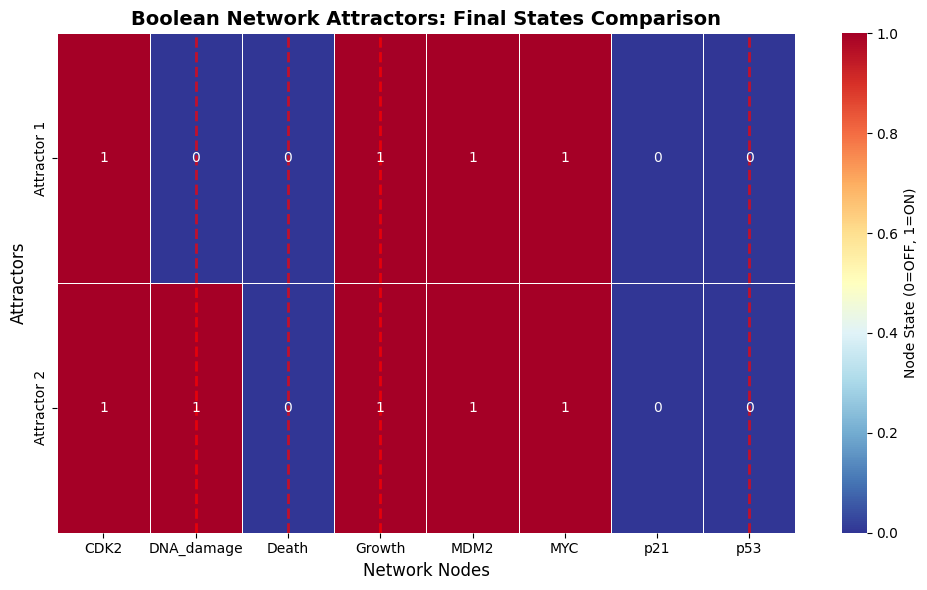

Analyzing 256 initial states...

Basin Sizes:
   → Healthy proliferating cell
 Attractor 1: 128 states ( 50.0%) → Healthy proliferating cell
   → Tumor-like (growth with DNA damage)
 Attractor 2: 128 states ( 50.0%) → Tumor-like (growth with DNA damage)


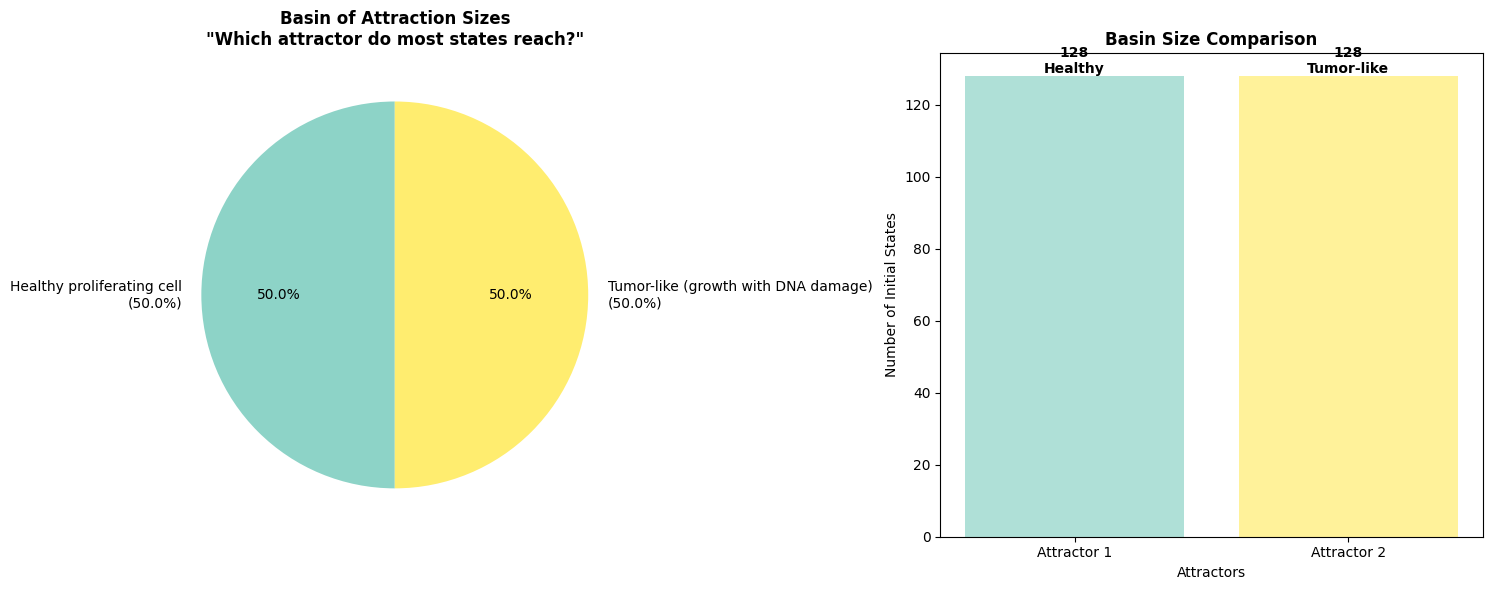

In [310]:
mut_C, nodes = build_normal_network()
mut_C = apply_mutation(mut_C, "MDM2_overexpression")

# Find attractors
attractors_C, node_names_C = find_attractors(mut_C, max_steps=15)

# Analyze basins
basin_data_C, attractor_map_C = analyze_basins(mut_C, attractors_C, node_names_C, max_steps=15)

### Mutation D: p21 Loss Attractor Analysis

Testing all 256 possible initial states...

FOUND 3 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy proliferating cell (normal growth, no stress)

Attractor 2: [0, 1, 1, 0, 0, 0, 0, 1]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → Cell death/apoptosis state (growth halted, death active)

Attractor 3: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Uncontrolled growth despite DNA damage (possible tumor-like state)


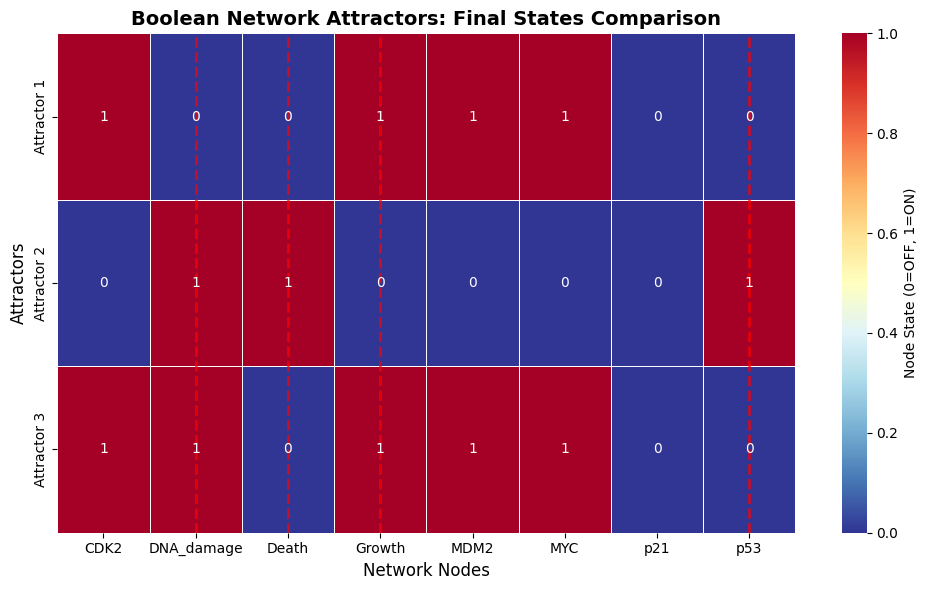

Analyzing 256 initial states...

Basin Sizes:
   → Healthy proliferating cell
 Attractor 1: 128 states ( 50.0%) → Healthy proliferating cell
   → Apostosis
 Attractor 2:  24 states (  9.4%) → Apostosis
   → Tumor-like (growth with DNA damage)
 Attractor 3:   8 states (  3.1%) → Tumor-like (growth with DNA damage)


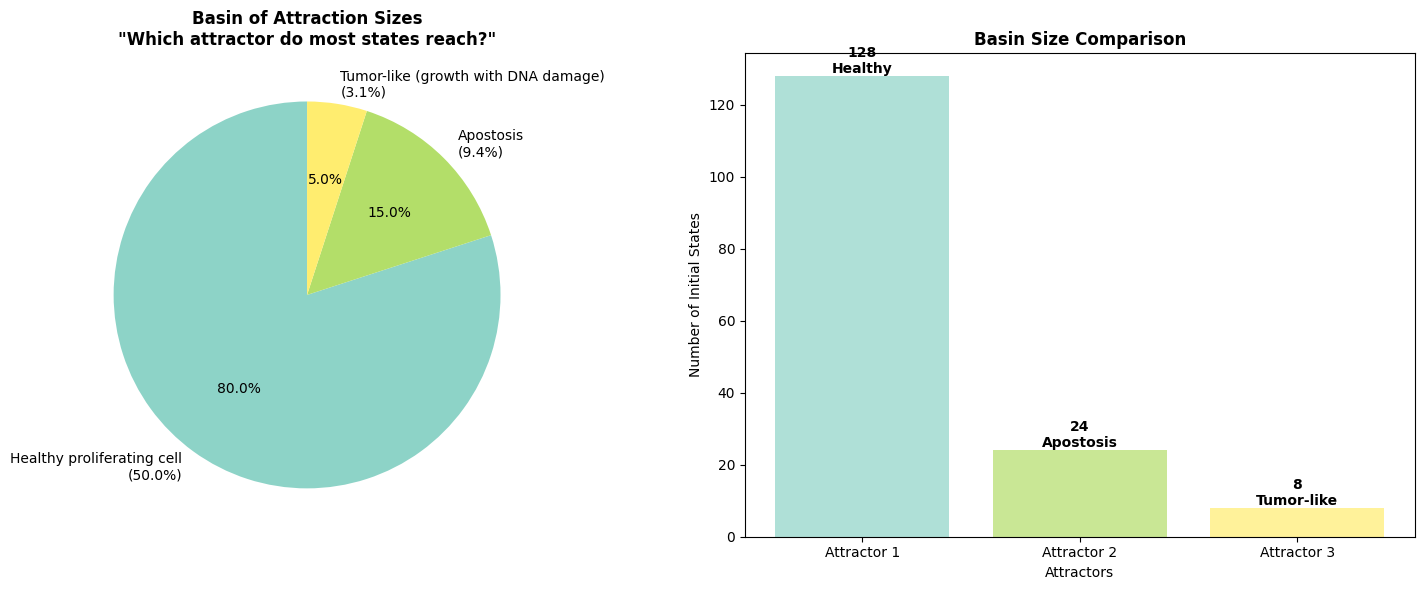

In [312]:
mut_D, nodes = build_normal_network()
mut_D = apply_mutation(mut_D, "p21_loss")

# Find attractors
attractors_D, node_names_D = find_attractors(mut_D, max_steps=15)

# Analyze basins
basin_data_D, attractor_map_D = analyze_basins(mut_D, attractors_D, node_names_D, max_steps=15)

## Conclusions:
* **Normal Network** - The network has three stable fates: *Healthy growth* (Growth=1, Death=0, p53=0), *Apoptosis* (Growth=0, Death=1, p53=1 with DNA damage), and a rare *Tumor-like* state (Growth=1 with DNA damage and p53=0). Basins show that outcomes are almost evenly split between Healthy (50.0%) and Apoptosis (46.9%), with the Tumor-like outcome rare (3.1%), indicating p53 effectively gates the DNA-damage response while leaving a small path to growth under damage when p53 is off.
* **Mutation A** - Here the network has only two fates: *Healthy growth* and *Tumor-like growth under DNA damage*, each capturing 50% of initial states. This shows that apoptosis is completely lost, and the system can no longer mount a protective DNA damage response.
* **Mutation B** - In this mutation we get the same three attractors and nearly identical basins as the normal network (Healthy ~50%, Apoptosis ~47%, Tumor-like ~3%), indicating the attractor landscape is largely unchanged. In this model, constant MYC does not bypass the p53-mediated damage checkpoint. It mainly reinforces growth in states where p53/p21 are already OFF.
* **Mutation C** - MDM2 OE eliminates the apoptosis attractor, leaving only *Healthy growth* and *Tumor-like growth with DNA damage*, each capturing 50% of initial states. This reflects persistent p53 suppression: the network can no longer execute a damage-induced death program, even when DNA damage is present.
* **Mutation D** - With p21 OFF, the *Healthy growth* attractor dominates (128 states) while the *Apoptosis* basin shrinks markedly (24 states) and *Tumor-like* remains small (8 states). This indicates that removing the p21 checkpoint strongly biases dynamics toward proliferation, although a p53-driven death fate still exists but is much less likely.